In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from tensorflow import keras
from toai.imports import *

from data import DataContainer
from image import *
from image_learner import ImageLearner
from transformations import ImageParser, ImageCropTransformation, ImageLRFlpTransformation

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when

In [3]:
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


In [3]:
DATA_DIR = Path('data')
TEMP_DIR = Path('temp')
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
TRAIN_DIR = DATA_DIR/'train'
images = [str(TRAIN_DIR/label_dir/val) for label_dir in os.listdir(TRAIN_DIR) for val in os.listdir(TRAIN_DIR/label_dir)]

In [5]:
train_df = pd.DataFrame()
train_df['path'] = images
train_df['label'] = train_df['path'].apply(lambda path : path.split("/")[2])

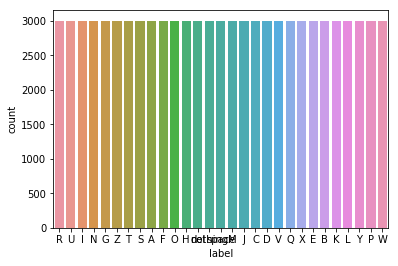

In [6]:
sns.countplot(x='label', data=train_df);

In [7]:
TEST_DIR = DATA_DIR/'test'
test_images = [str(TEST_DIR/val) for val in os.listdir(TEST_DIR)]

In [8]:
test_df = pd.DataFrame()
test_df['path'] = test_images
test_df['label'] = test_df['path'].apply(lambda path : path.split("/")[-1].split("_")[0])

In [9]:
test_df.head()

,path,label
0,data/test/F_test.jpg,F
1,data/test/G_test.jpg,G
2,data/test/L_test.jpg,L
3,data/test/M_test.jpg,M
4,data/test/R_test.jpg,R


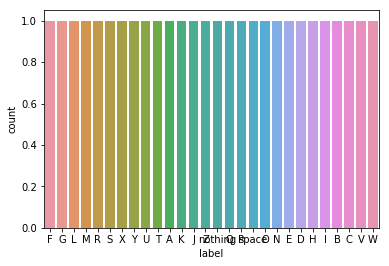

In [10]:
sns.countplot(x='label', data=test_df);

In [11]:
IMG_DIMS = (150, 150, 3)

In [12]:
train_data, validation_data = train_test_split(train_df, test_size=0.2)

In [13]:
test_data = test_df.copy()

In [14]:
[data.shape for data in [train_data, validation_data]]

[(69600, 2), (17400, 2)]

In [25]:
base_config = ImageDatasetConfig(
    img_dims=IMG_DIMS,
    batch_size=16,
    preprocess_pipeline=[
        ImageParser(),
        ImageCropTransformation(IMG_DIMS)
    ],
)

train_dataset = ImageDataset(base_config.copy(
        preprocess_pipeline=[
            ImageLRFlpTransformation()
        ],
        shuffle=True,
    )).build_from_df(train_data, 'path', 'label')

data_container = DataContainer(
    train=train_dataset,
    validation=ImageDataset(base_config.copy(
        preprocess_pipeline = [
            ImageLRFlpTransformation(),
        ],
    ))
        .with_label_map(train_dataset.label_map)
        .build_from_df(validation_data, 'path', 'label'),
    test=ImageDataset(base_config.copy(
        preprocess_pipeline=[
            ImageCropTransformation(IMG_DIMS)
        ],
    )).build_from_df(test_data, 'path', 'label'),
)

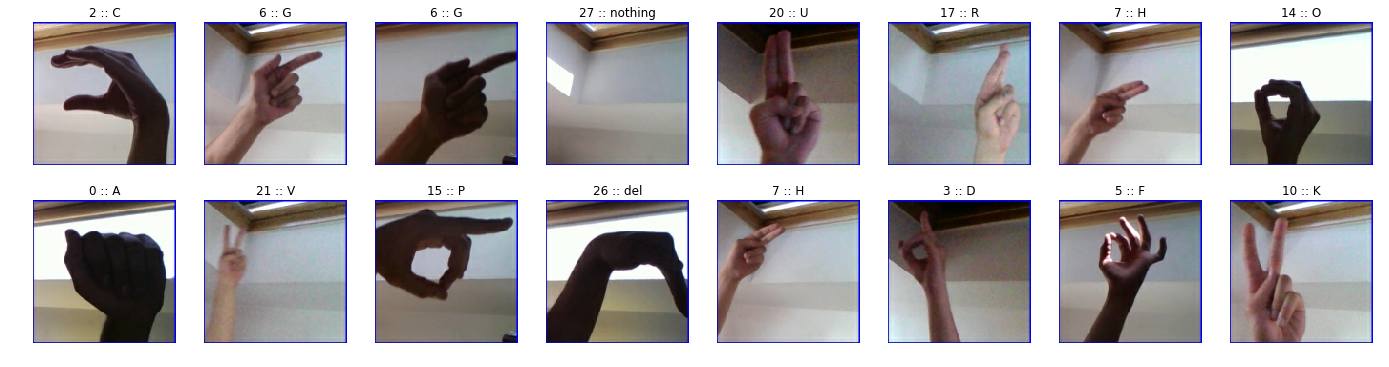

In [26]:
data_container.train.show()

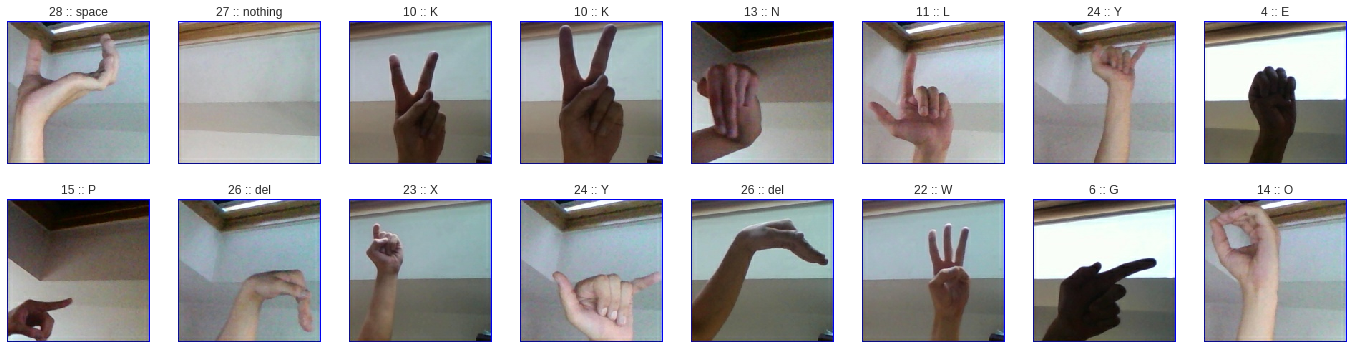

In [18]:
data_container.validation.show()

In [27]:
learner = ImageLearner(
    model_path=Path('xception'),
    data=data_container,
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    dropout=0.2,
)

Existing model data path exists
Loading architecture and weights from xception
Model loaded successfully


In [28]:
learner.auto_train(
    easing_epochs=0,
    epochs=0,
    optimizer=keras.optimizers.Adam,
    lr=1e-3,
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[keras.metrics.sparse_categorical_accuracy]
)

Starting model training
Loading weights only from xception/weights.h5
Model loaded successfully
Model training completed


In [29]:
learner.analyze_dataset(verbose=1)

 1329/17400 [=>............................] - ETA: 18:35

KeyboardInterrupt: 